# Emotion Classification in Texts using Scikit-learn 

Classifying short messages into five emotion categories. We will prepare our dataset (nltk and regular expressions) and vectorize words using TF-IDF (term frequency-inverse document frequency) metric. Later we will use classifiers provided by scikit-learn and classify sentences into five emotion categories: joy, sadness, anger, fear, and neutral.

### Workflow 
* Importing Dataset
* Text Preprocessing
* Text Representation
* Classifiers: Naive Bayes, Linear Regression, Random Rorrrest, SVM
* Evaluation: F1 scores and Confussion Matrix
* Saving the Model


In [1]:
import pandas as pd

df = pd.read_pickle('Cleaned_data.pkl')

In [2]:
import pandas as pd
import numpy as np

# text preprocessing
from nltk import word_tokenize
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
import re

# plots and metrics
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

# feature extraction / vectorization
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# classifiers
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline

# save and load a file
import pickle

## 1. Import Dataset

Text-Emotion Dataset was split into training 70% and testing 30%


In [10]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Load your data from 'Cleaned_data.pkl'
df = pd.read_pickle('Cleaned_data.pkl')

# Define the class names
class_names = ['joy', 'sadness', 'anger', 'fear', 'love', 'surprise']

# Initialize empty DataFrames to store the train and test data
df_train = pd.DataFrame(columns=['text', 'emotions'])
df_test = pd.DataFrame(columns=['text', 'emotions'])

# Iterate over each class to split the data
for emotion in class_names:
    # Filter the data for the current class
    class_data = df[df['emotions'] == emotion]
    
    # Split the data into train and test for the current class
    class_train, class_test = train_test_split(class_data, test_size=0.2, random_state=42)
    
    # Take only 14,971 samples for the training set
    class_train = class_train.head(14971)
    
    # Append the split data to the overall train and test DataFrames
    df_train = pd.concat([df_train, class_train])
    df_test = pd.concat([df_test, class_test])

# Shuffle the training and validation data
df_train = df_train.sample(frac=1, random_state=42).reset_index(drop=True)
df_test = df_test.sample(frac=1, random_state=42).reset_index(drop=True)

# Separate features (X) and labels (y) for both sets
X_train = df_train['text']
X_test = df_test['text']
y_train = df_train['emotions']
y_test = df_test['emotions']

# Print the size of the training and validation sets
print('Size of the training set: %s' % len(X_train))
print('Size of the validation set: %s' % len(X_test))

data = pd.concat([df_train, df_test])
print(data.emotions.value_counts())

data.head()

Size of the training set: 86832
Size of the validation set: 83957
emotions
joy         43326
sadness     39380
anger       26715
fear        24514
love        21882
surprise    14972
Name: count, dtype: int64


,text,emotions
0,i feel super super fortunate to have the oppor...,joy
1,im not feeling particularly reassured,joy
2,i feel like now we know what we need to do in ...,joy
3,i have a sneaking feeling theres a humorous pr...,joy
4,i feel like a naughty house elf,love


In [ ]:
# from sklearn.model_selection import train_test_split

# df_train, df_test = train_test_split(df, test_size=0.2, random_state=42)

# X_train = df_train.text
# X_test = df_test.text

# y_train = df_train.emotions
# y_test = df_test.emotions

# class_names = ['joy', 'sadness', 'anger', 'fear', 'love', 'surprise']
# data = pd.concat([df_train, df_test])

# print('size of training set: %s' % (len(df_train['text'])))
# print('size of validation set: %s' % (len(df_test['text'])))
# print(data.emotions.value_counts())

# data.head()

### *Plotting confusion matrix for later evaluation 

In [17]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    '''
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    '''
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    fig, ax = plt.subplots()

    # Set size
    fig.set_size_inches(12.5, 7.5)
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    ax.grid(False)

    # We want to show all ticks...
    ax.set(xticks=np.arange(len(classes)),
           yticks=np.arange(len(classes)),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(len(classes)):
        for j in range(len(classes)):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


## 2. Text Preprocessing

Here are some preprocessing steps to consider:
* Removing noise: html markups, urls, non-ascii symbols, trailing whitespace etc.
* Removing punctuation
* Normalizing emoticons
* Negation handling
* Tokenization: split text into word tokens
* Stopword removal
* Stemming or lemmatization

However, most of these steps did not improve our classification results. Since our data was mostly taken from written dialogs it was almost ready to use.

In [4]:
def preprocess_and_tokenize(data):    

    # #remove html markup
    # data = re.sub("(<.*?>)", "", data)

    # #remove urls
    # data = re.sub(r'http\S+', '', data)
    
    # #remove hashtags and @names
    # data= re.sub(r"(#[\d\w\.]+)", '', data)
    # data= re.sub(r"(@[\d\w\.]+)", '', data)

    # #remove punctuation and non-ascii digits
    # data = re.sub("(\\W|\\d)", " ", data)
    
    #remove whitespace
    data = data.strip()
    
    # tokenization with nltk
    data = word_tokenize(data)
    
    # stemming with nltk
    porter = PorterStemmer()
    stem_data = [porter.stem(word) for word in data]
        
    return stem_data

## 3. Text Representation

Vectorizing text using Term Frequency technique (Term Frequency(TF) — Inverse Dense Frequency(IDF))
* Tekenize with our preprocess_and_tokenize
* Find it’s TF = (Number of repetitions of word in a document) / (# of words in a document)
* IDF = log(# of documents / # of documents containing the word)

In [5]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [6]:
# TFIDF, unigrams and bigrams
vect = TfidfVectorizer(tokenizer=preprocess_and_tokenize, sublinear_tf=True, norm='l2', ngram_range=(1, 2))

# fit on our complete corpus
vect.fit_transform(data.text)

# transform testing and training datasets to vectors
X_train_vect = vect.transform(X_train)
X_test_vect = vect.transform(X_test)

# 6m 5.6s

# 1m 57.9s balanced

C:\Users\Dan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\feature_extraction\text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


## 4. Classifiers

###  Naive Bayes

In [7]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
nb = MultinomialNB()

nb.fit(X_train_vect, y_train)

ynb_pred = nb.predict(X_test_vect)

# plot_confusion_matrix(y_test, ynb_pred, classes=class_names, normalize=True, title='Normalized confusion matrix')
# plt.show()

Accuracy: 82.08%

F1 Score: 82.08

COnfusion Matrix:
 [[10238   494   243   442   316    11]
 [  300  8251   111   235   184   462]
 [  605   825 22037  3886   757   245]
 [   64    46   327  6381    81    12]
 [ 1053  1056   711  1364 20170    55]
 [   53   599   224   208    75  1836]]


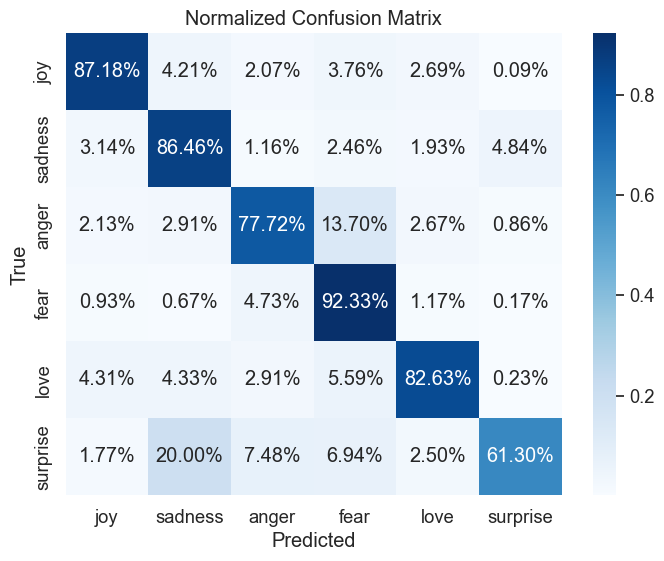

In [8]:
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

print("Accuracy: {:.2f}%".format(accuracy_score(y_test, ynb_pred) * 100))
print("\nF1 Score: {:.2f}".format(f1_score(y_test, ynb_pred, average='micro') * 100))
print("\nCOnfusion Matrix:\n", confusion_matrix(y_test, ynb_pred))

# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_test, ynb_pred)

# Normalize the confusion matrix
conf_matrix = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

# Create a figure and axis
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)  # Adjust the font size for better visualization
sns.heatmap(conf_matrix, annot=True, cmap="Blues",
            xticklabels=class_names, yticklabels=class_names, fmt=".2%")

# Add labels and a title
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Normalized Confusion Matrix')

# Show the plot
plt.show()

###  Random Forrest

In [9]:
rf = RandomForestClassifier(n_estimators=10)
rf.fit(X_train_vect, y_train)

In [20]:
rf = RandomForestClassifier(n_estimators=1000, n_jobs=-1)
rf.fit(X_train_vect, y_train)

yrf_pred = rf.predict(X_test_vect)

In [ ]:
print("Accuracy: {:.2f}%".format(accuracy_score(y_test, yrf_pred) * 100))
print("\nF1 Score: {:.2f}".format(f1_score(y_test, yrf_pred, average='micro') * 100))
print("\nCOnfusion Matrix:\n", confusion_matrix(y_test, yrf_pred))

# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_test, yrf_pred)

# Normalize the confusion matrix
conf_matrix = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

# Create a figure and axis
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)  # Adjust the font size for better visualization
sns.heatmap(conf_matrix, annot=True, cmap="Blues",
            xticklabels=class_names, yticklabels=class_names, fmt=".2%")

# Add labels and a title
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Normalized Confusion Matrix')

# Show the plot
plt.show()

# plot_confusion_matrix(y_test, yrf_pred, classes=class_names, normalize=True, title='Normalized confusion matrix')
# plt.show()

###  Logistic Regression

In [12]:
log = LogisticRegression(solver='lbfgs', multi_class='auto', max_iter=1000)
log.fit(X_train_vect, y_train)

ylog_pred = log.predict(X_test_vect)

Accuracy: 87.29%

F1 Score: 87.29

COnfusion Matrix:
 [[10722   356   165   157   277    67]
 [  327  8049   104    94   190   779]
 [  502   283 23928  2537   584   521]
 [   54    20   367  6339    70    61]
 [ 1003   638   597   465 21503   203]
 [    6   181    29    17    15  2747]]


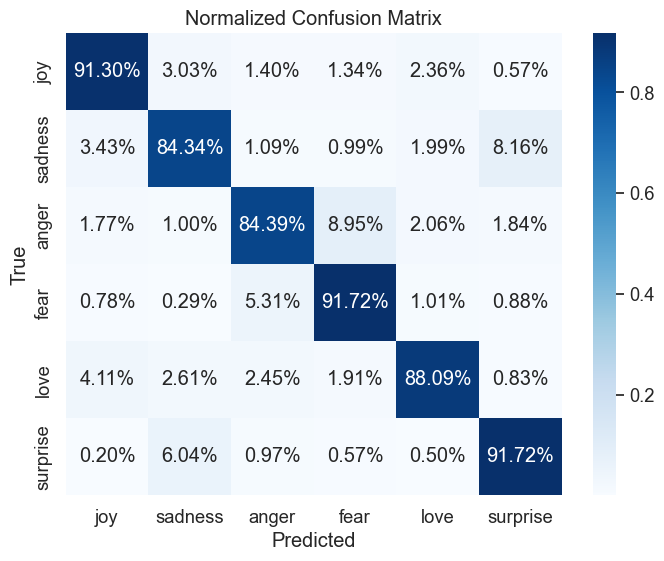

In [14]:
print("Accuracy: {:.2f}%".format(accuracy_score(y_test, ylog_pred) * 100))
print("\nF1 Score: {:.2f}".format(f1_score(y_test, ylog_pred, average='micro') * 100))
print("\nCOnfusion Matrix:\n", confusion_matrix(y_test, ylog_pred))

# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_test, ylog_pred)

# Normalize the confusion matrix
conf_matrix = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

# Create a figure and axis
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)  # Adjust the font size for better visualization
sns.heatmap(conf_matrix, annot=True, cmap="Blues",
            xticklabels=class_names, yticklabels=class_names, fmt=".2%")

# Add labels and a title
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Normalized Confusion Matrix')

# Show the plot
plt.show()

###  Linear Support Vector

In [15]:
svc = LinearSVC(tol=1e-05)
svc.fit(X_train_vect, y_train)

ysvm_pred = svc.predict(X_test_vect)

Accuracy: 88.23%

F1 Score: 88.23

COnfusion Matrix:
 [[10829   384   108    96   272    55]
 [  324  8168    62    58   144   787]
 [  428   281 24172  2498   455   521]
 [   52    33   419  6278    70    59]
 [  901   651   395   318 21959   185]
 [    8   259    32    15    12  2669]]


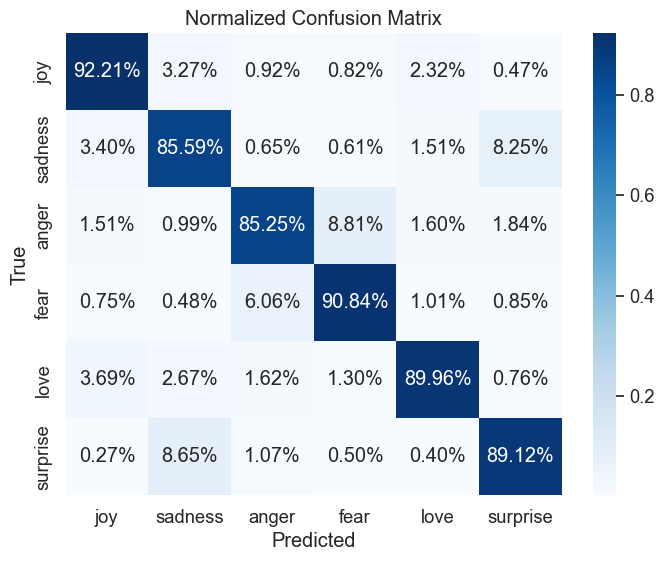

In [16]:
print("Accuracy: {:.2f}%".format(accuracy_score(y_test, ysvm_pred) * 100))
print("\nF1 Score: {:.2f}".format(f1_score(y_test, ysvm_pred, average='micro') * 100))
print("\nCOnfusion Matrix:\n", confusion_matrix(y_test, ysvm_pred))

# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_test, ysvm_pred)

# Normalize the confusion matrix
conf_matrix = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

# Create a figure and axis
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)  # Adjust the font size for better visualization
sns.heatmap(conf_matrix, annot=True, cmap="Blues",
            xticklabels=class_names, yticklabels=class_names, fmt=".2%")

# Add labels and a title
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Normalized Confusion Matrix')

# Show the plot
plt.show()

## 4. Saving the tf-idf + SVM Model 


In [17]:
#Create pipeline with our tf-idf vectorizer and LinearSVC model
svm_model = Pipeline([
    ('tfidf', vect),
    ('clf', svc),
])

In [18]:
# save the model
filename = 'models/tfidf_svm.sav'
pickle.dump(svm_model, open(filename, 'wb'))

In [19]:
model = pickle.load(open(filename, 'rb'))

message = 'delivery was hour late and my pizza is cold!' 
model.predict([message])

array(['anger'], dtype=object)